In [1]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv

load_dotenv() 

True

In [2]:
search_tool = TavilySearch(
  tavily_api_key=os.getenv("TAVILY_API_KEY"),
  max_results=5,
  topic="news",
)

In [3]:
search_tool.invoke("Chelsea last results in EPL?")

{'query': 'Chelsea last results in EPL?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Latest Chelsea Scores: Scores from all Chelsea's Premier League games ...",
   'url': 'https://www.sportingnews.com/us/soccer/chelsea/scores',
   'content': 'Follow all the scores from Chelsea with real-time Premier League scores, live match updates, and final results right here on Sporting News. Crafted for fans since 1886. Company. About Us',
   'score': 0.5637388,
   'raw_content': None},
  {'title': 'Chelsea FC Scores, Results & Season Archives | Premier League',
   'url': 'https://www.premierleague.com/clubs/4/Chelsea/results',
   'content': 'View scores, results & season archives, for all competitions involving Chelsea FC, on the official website of the Premier League.',
   'score': 0.512376,
   'raw_content': None},
  {'title': 'Chelsea FC Team News, Fixtures & Results 2024/2025 | Premier League',
   'url': 'https://www.premierleague.com/clubs/4/Chelsea

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
llm = ChatOpenAI(
  model="deepseek/deepseek-r1",
  temperature=0,
  openai_api_key=os.getenv("OPENROUTER_API_KEY"),
  base_url="https://openrouter.ai/api/v1",
)


In [6]:
class LLMNode:
  def __init__(self, llm: ChatOpenAI):
    self.llm = llm

  def __call__(self, state: State):
    return {'messages': [self.llm.invoke(state['messages'])]}
  
llm_node = LLMNode(llm.bind_tools([search_tool]))

In [7]:
tool_node = ToolNode([search_tool])

In [8]:
graph_builder.add_node('llm', llm_node)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'llm')
graph_builder.add_conditional_edges('llm', tools_condition)
graph_builder.add_edge('tools', 'llm')

In [9]:
agent = graph_builder.compile()

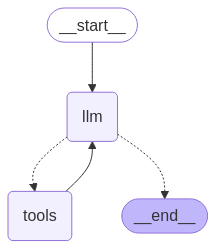

In [10]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
for m in llm.stream("Chelsea last results in EPL?"):
  print(m.content, end="")

Chelsea's most recent results in the English Premier League (EPL) as of the conclusion of the 2023-2024 season include:

- **May 19, 2024**: Chelsea 2-1 Bournemouth (Win)  
- **May 15, 2024**: Brighton 1-2 Chelsea (Win)  
- **May 11, 2024**: Aston Villa 2-2 Chelsea (Draw)  
- **May 5, 2024**: Nottingham Forest 1-0 Chelsea (Loss)  
- **April 30, 2024**: Chelsea 5-0 West Ham (Win)  

Their final match of the season was a **2-1 victory over Bournemouth**, securing a 6th-place finish and qualification for European competition. For real-time updates, always refer to official Premier League sources or trusted sports news platforms.

In [13]:
for step in agent.stream(
  {"messages":"Can you research Hopper to Blackwell semiconductor transition? Nvidia is changing it's product line and I want to understand why?"},
   stream_mode="values"
):
  step['messages'][-1].pretty_print()

================================ Human Message =================================

Can you research Hopper to Blackwell semiconductor transition? Nvidia is changing it's product line and I want to understand why?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_91k76ubct1zg7f0ynq8l64cp)
 Call ID: call_91k76ubct1zg7f0ynq8l64cp
  Args:
    query: Nvidia Hopper to Blackwell semiconductor transition reasons
    include_domains: ['nvidia.com', 'techcrunch.com', 'anandtech.com', 'tomshardware.com', 'arstechnica.com']
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "Nvidia Hopper to Blackwell semiconductor transition reasons", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.tomshardware.com/pc-components/gpus/nvidias-next-gen-ai-gpu-revealed-blackwell-b200-gpu-delivers-up-to-20